# Classification

MNIST is  set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import fetch_openml
import matplotlib as mpl
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Loading the dataset
mnist = fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X = mnist['data']
y = mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

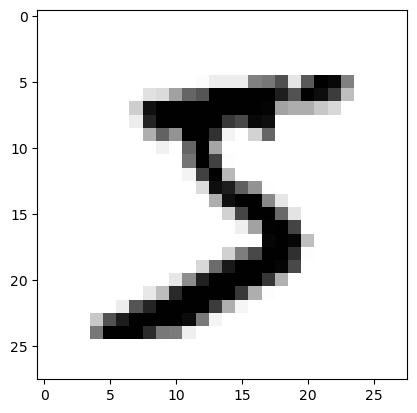

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation='nearest');

In [9]:
y[0]

'5'

In [10]:
y.dtype

dtype('O')

In [11]:
# Converting y dtype to integer
y = y.astype(np.uint8)
y.dtype

dtype('uint8')

In [12]:
# Creating train test set
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Binary Classification 

Our labels only consists of 5's

In [13]:
# Creating sets where it returns true for all instances of 5

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

So far, the classifier guessed it right

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# A custom classifier that 
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

This classifier always predicts the class 'not 5' (or the negative class) for every instance. Hence the name Never5Classifier - it will never predict the class represented by the digit '5'.

In [18]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred =cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

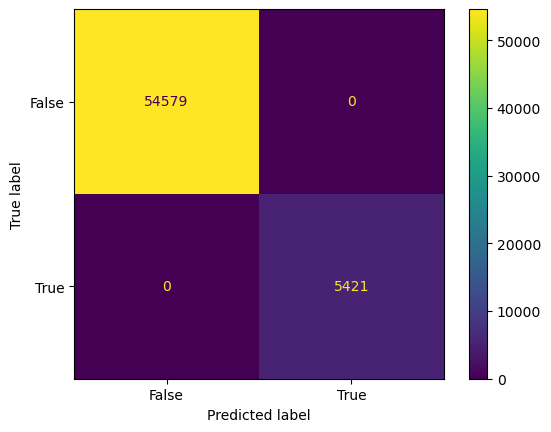

In [53]:
y_train_perfect_predictions = y_train_5
cm = confusion_matrix(y_train_5,y_train_perfect_predictions,labels = sgd_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sgd_clf.classes_)
disp.plot();

In [22]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

Precision : When an image is 5. It is right only 83% of the time

In [23]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

Recall: It is able to detect only 65% of the 5's

## Manualy Adusting the threshold to increase precision

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

# Initial value
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_scores, y_some_digit_pred

(array([2164.22030239]), array([ True]))

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recall, thresholds = precision_recall_curve(y_train_5,y_scores)

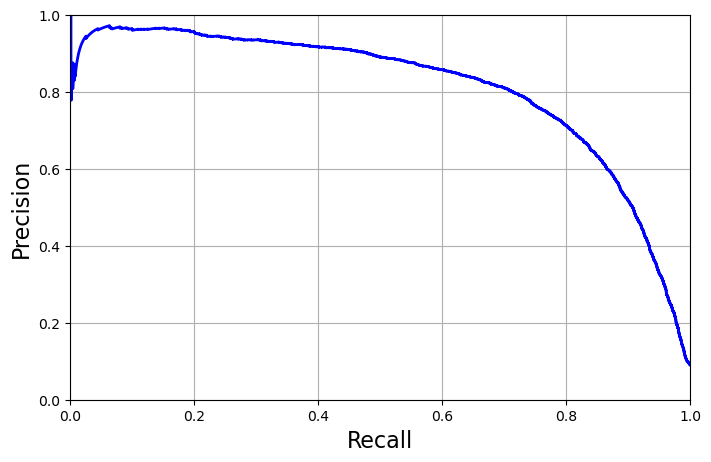

In [28]:
# Plot precision vs recall

def plot_precision_recall(precision,recall):
    plt.plot(recall,precision,"b-",linewidth=2)
    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)


plt.figure(figsize=(8,5))
plot_precision_recall(precisions,recall)

In [29]:
thresholds_90_precision = thresholds[np.argmax(precisions>=0.90)]
thresholds_90_precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [31]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

Eventhough the precision is high the recall is quite low

ROC

In [33]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

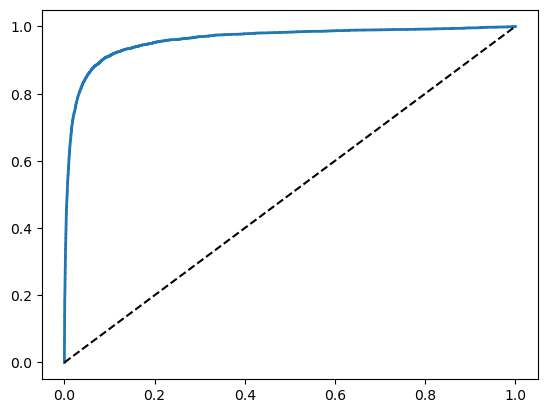

In [34]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label =label)
    plt.plot([0,1],[0,1],'k--')
    [...]

plot_roc_curve(fpr,tpr)

AUC_ROC

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Consider Precision Recall plot when positive class is rare or false positives are more important than false negatives.

## Trying Random Forest Classifier

In [36]:
# For Random Forest Clasifier

from sklearn.ensemble import RandomForestClassifier

forest_clf  = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [37]:
y_scores_forest = y_probas_forest[:,1] # only the proba of positive instances
fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_scores_forest)

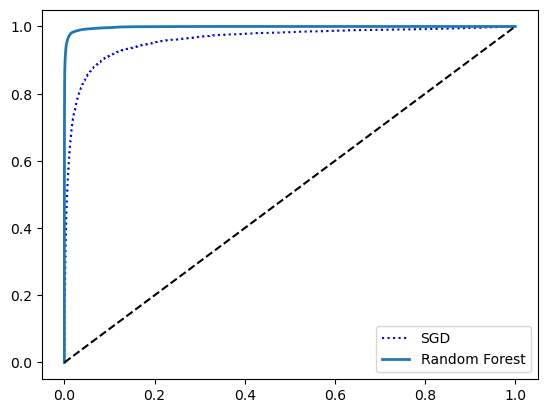

In [38]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right");

In [73]:
print("The ROC-AUC score is ;",roc_auc_score(y_train_5,y_scores_forest)*100)

The ROC-AUC score is ; 99.83436731328145


In [40]:
y_preds_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)

In [74]:
print("Precision ;",precision_score(y_train_5,y_preds_forest)*100)

Precision ; 99.0508331575617


In [75]:
print("Recall ;",recall_score(y_train_5,y_preds_forest)*100)

Recall ; 86.62608374838591


Pretty Good Scores for all three metrics

# Multiclass Classification